<a href="https://colab.research.google.com/github/ouhenio/StyleGAN3-CLIP-notebooks/blob/fix-wikiart-model/StyleGAN3%2BCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **StyleGAN3 + CLIP 🖼️**

## Generate images from text prompts using NVIDIA's StyleGAN3 with CLIP guidance.

Head over [here](https://github.com/ouhenio/StyleGAN3-CLIP-notebook) if you want to be up to date with the changes to this notebook and play with other alternatives.

The original code was written by [nshepperd](https://twitter.com/nshepperd1)* (https://github.com/nshepperd), and later edited by [Eugenio Herrera](https://github.com/ouhenio).

Thanks to [Katherine Crowson](https://twitter.com/RiversHaveWings) (https://github.com/crowsonkb) for coming up with many improved sampling tricks, as well as some of the code.

----

(*) nshepperd originally made [this notebook](https://colab.research.google.com/drive/1eYlenR1GHPZXt-YuvXabzO9wfh9CWY36#scrollTo=LQf7tzBQ8rn2).

(**) The interface is inspired by [this notebook](https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP(Updated).ipynb), done by Jakeukalane and Avengium (Angel).

(***) For more information about StyleGAN3, [visit the official repository](https://github.com/NVlabs/stylegan3).

In [17]:
#@markdown #**Install libraries** 🏗️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

# !pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !git clone https://github.com/NVlabs/stylegan3
# !git clone https://github.com/openai/CLIP
# !pip install -e ./CLIP
# !pip install einops ninja

import sys
# sys.path.append('../stylegan3')
sys.path.append('../CLIP')
sys.path.append('./stylegan2-ada-pytorch/')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
import dnnlib
import legacy
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
# from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [18]:
#@markdown #**Define necessary functions** 🛠️

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.1)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

In [19]:
#@markdown #**Model selection** 🎭


#@markdown There are 4 pre-trained options to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---


# Choose between these pretrained models
ckpt_paths = {
  'cat': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl',
  'dog': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl',
  'wild': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl',
  'brecahad': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl',
  'cifar10': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl',
  'ffhq': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl',
  'metfaces': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl'
}


network_pkl = ckpt_paths['ffhq']

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
# with open(fetch_model(network_url), 'rb') as fp:
#   G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


In [31]:
#@markdown #**Parameters** ✍️
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

# texts = "A photo of a red-eyed cat"#@param {type:"string"}
# texts = "A photo of a woman"
# texts = "A photo of a man impersonating Obama"
texts = "A man with sunglasses"

steps = 200 #@param {type:"number"}
seed = 2222 #@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]

  0%|          | 0/200 [00:00<?, ?it/s]

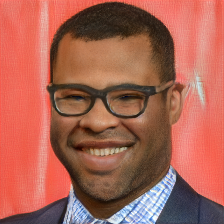

Image 0/200 | Current loss: 0.8155544996261597


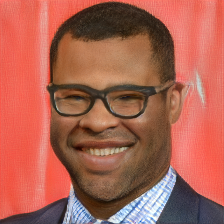

Image 10/200 | Current loss: 0.7832471132278442


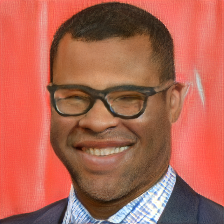

Image 20/200 | Current loss: 0.7658704519271851


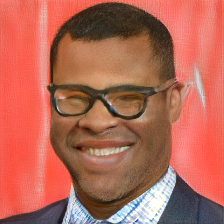

Image 30/200 | Current loss: 0.7530227899551392


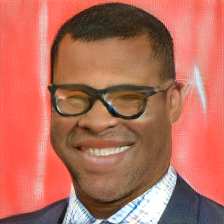

Image 40/200 | Current loss: 0.7422876358032227


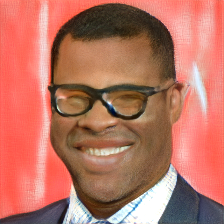

Image 50/200 | Current loss: 0.7356796264648438


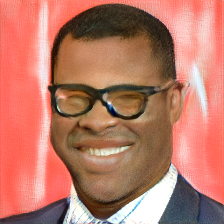

Image 60/200 | Current loss: 0.7270022630691528


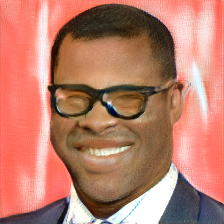

Image 70/200 | Current loss: 0.7255172729492188


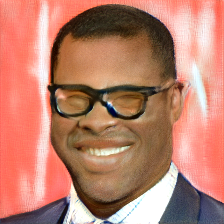

Image 80/200 | Current loss: 0.7152499556541443


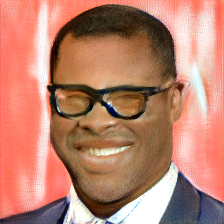

Image 90/200 | Current loss: 0.713529646396637


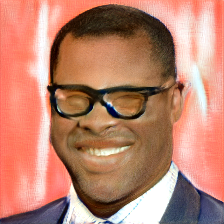

Image 100/200 | Current loss: 0.7059319019317627


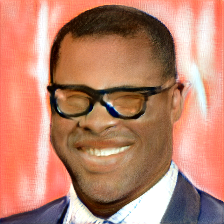

Image 110/200 | Current loss: 0.7008680105209351


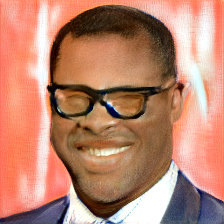

Image 120/200 | Current loss: 0.6972678899765015


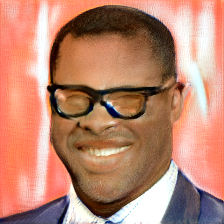

Image 130/200 | Current loss: 0.6978142261505127


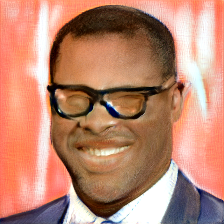

Image 140/200 | Current loss: 0.6934882402420044


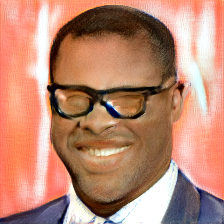

Image 150/200 | Current loss: 0.6914018392562866


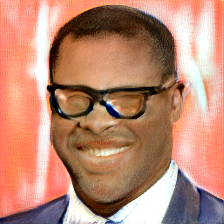

Image 160/200 | Current loss: 0.6884088516235352


In [32]:
#@markdown #**Run the model** 🚀

# Actually do the run

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run(timestring):
  torch.manual_seed(1)

  # Init
  # Sample 32 inits and choose the one closest to prompt
  from_noise = 0
  if from_noise:
    with torch.no_grad():
      qs = []
      losses = []
      for _ in range(8):
        q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
        images = G.synthesis(q * w_stds + G.mapping.w_avg)
        embeds = embed_image(images.add(1).div(2))
        loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
        i = torch.argmin(loss)
        qs.append(q[i])
        losses.append(loss[i])
      qs = torch.stack(qs)
      losses = torch.stack(losses)
      # print(losses)
      # print(losses.shape, qs.shape)
      i = torch.argmin(losses)
      q = qs[i].unsqueeze(0).requires_grad_()

  else:
    q = np.load('/home/user/code/Image2StyleGAN3/out/peele/latents/3600_peele.npy')
    # q = np.load('/home/user/code/Image2StyleGAN3/out/obama/latents/3900_obama.npy')
    # q = np.load('/home/user/code/Image2StyleGAN3/out/cat/latents/3900_cat.npy')
    q = (q - G.mapping.w_avg.cpu().numpy()) / w_stds.cpu().numpy()
    q = torch.from_numpy(q).to(device).requires_grad_()
  
  
  # Sampling loop
  q_ema = q
  opt = torch.optim.Adam([q], lr=0.005, betas=(0.0,0.999))
  opt = torch.optim.AdamW([q], lr=0.005)
  # opt = torch.optim.SGD([q], lr=2)
  
  
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='random')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='random')

    plot_str = 'peele_woman'
    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
      pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
      os.makedirs(f'newsamples/{plot_str}', exist_ok=True)
      pil_image.save(f'newsamples/{plot_str}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass

In [6]:
#@markdown #**Save images** 📷
#@markdown A `.tar` file will be saved inside *samples* and automatically downloaded, unless you previously ran the Google Drive cell,
#@markdown in which case it'll be saved inside your previously created drive *samples* folder.

# archive_name = "optional"#@param {type:"string"}

# archive_name = slugify(archive_name)

# if archive_name != "optional":
#   fname = archive_name
#   # os.rename(f'samples/{timestring}', f'samples/{fname}')
# else:
#   fname = timestring
# # Save images as a tar archive
# !tar cf samples/{fname}.tar samples/{timestring}
# if os.path.isdir('drive/MyDrive/samples'):
#   shutil.copyfile(f'samples/{fname}.tar', f'drive/MyDrive/samples/{fname}.tar')
# else:
#   files.download(f'samples/{fname}.tar')

In [7]:
# #@markdown #**Generate video** 🎥

# #@markdown You can edit frame rate and stuff by double-clicking this tab.

# frames = os.listdir(f"samples/{timestring}")
# frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

# init_frame = 1 #This is the frame where the video will start
# last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

# min_fps = 10
# max_fps = 60

# total_frames = last_frame-init_frame

# #Desired video time in seconds
# video_length = 14 #@param {type:"number"}
# #Video filename
# video_name = "" #@param {type:"string"}
# video_name = slugify(video_name)

# if not video_name:
#   video_name = "video"
# # frames = []
# # tqdm.write('Generating video...')
# # for i in range(init_frame,last_frame): #
# #     filename = f"samples/{timestring}/{i:04}.jpg"
# #     frames.append(Image.open(filename))

# fps = np.clip(total_frames/video_length,min_fps,max_fps)

# print("Generating video...")
# !ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# # from subprocess import Popen, PIPE
# # p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# # for im in tqdm(frames):
# #     im.save(p.stdin, 'PNG')
# # p.stdin.close()

# print("The video is ready")

In [8]:
# #@markdown #**Download video** 📀
# #@markdown If you're activated the download to GDrive option, the video will be save there. Don't worry about overwritting issues for colliding filenames, an id will be added to them to avoid this.

# #Video filename
# to_download_video_name = "" #@param {type:"string"}
# to_download_video_name = slugify(to_download_video_name)

# if not to_download_video_name:
#   to_download_video_name = "video"


# from google.colab import files
# if os.path.isdir('drive/MyDrive/samples'):
#   filelist = glob.glob(f'drive/MyDrive/samples/{to_download_video_name}*.mp4')
#   video_count = len(filelist)
#   if video_count:
#     final_video_name = f"{to_download_video_name}{video_count}"
#   else:
#     final_video_name = to_download_video_name
#   shutil.copyfile(f'samples/{video_name}.mp4', f'drive/MyDrive/samples/{final_video_name}.mp4')
# else:
#   files.download(f"samples/{to_download_video_name}.mp4")